# Introduction

# Preparing Environment

The powershell in the assosiated GitHub repository allows for this notebook to download the datasetfor this project, provided you complete the ".env" file with your kaggle API key, and file path.

This script was written, so that this notebook may be run, tested, and modified either in the kaggle environment, or on a configured windows machine.

In [124]:
import re
import warnings
import math
import dotenv
import kagglehub
import os
import subprocess
import ipywidgets
import random

import sklearn_pandas as sk
import pandas as pd
import tensorflow as tf
import keras as ks
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sb


from IPython.display import Image, display
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
from scipy.stats import anderson, lognorm, probplot, shapiro
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


try:
    dotenv.load_dotenv()
except:
    print("--Dotenv not loaded--")


# Check for Kaggle environment and set the file path
if os.path.exists("/kaggle/input/churn-modelling/Churn_Modelling.csv"):
    # Kaggle
    file_path = "/kaggle/input/churn-modelling/Churn_Modelling.csv"
else:
    # Local
    file_path = (str((os.getenv("LOCAL_FILE_LOCATION"))))

# Load Dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully!")
except FileNotFoundError:
    print(f"Error: File not found at : file_path")
    try:
        print("Attempting to run download_data_ps1")
        path = os.getenv("SCRIPT_PATH")
        subprocess.run(["powershell", "-ExecutionPolicy", "Bypass", "-File", path],
                       check = True, capture_output =  True, text = True)
        print("Powershell Download Script Run Successfully. Now attempting to reload dataset...")
        df = pd.read_csv(file_path)
        if df is not None and not df.empty:
            print("Dataset Loaded Successfully")
        else:
            print("Data not loaded")
    except Exception as e:
        print(f"Error running powershell script: {e}")
        df = None

# Display the first few rows of the dataset
if df is not None:
    display(df.head())

# Set random seed for reproducability
RANDOM = 123
tf.keras.utils.set_random_seed(RANDOM)
tf.config.experimental.enable_op_determinism()
random.seed(RANDOM)

Dataset Loaded Successfully!


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Cleaning Dataset

The target variable is the last variable in this dataset. It is called "Exited". It is binary, where a 1 represents a customer closing thier account, and a 0 represents a retained customer.

Let's preview the data in order to understand what we have to work with.

First, I will drop the insignificant variables, which are the "RowNumber", "CustomerId", and "Surname" variables. They are arbitrary, and not useful for our algorithm.

In [125]:
X = df.iloc[:, 3:-1]
Y = df.iloc[:,-1:]

display(X.head())
display(Y.head())

display(f"{X.shape=}")
display(f"{Y.shape=}")

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


,Exited
0,1
1,0
2,1
3,0
4,0


'X.shape=(10000, 10)'

'Y.shape=(10000, 1)'

As you can see, we have 10,000 observations for both the predictor and target variables.

Now, we will check the dataset for any Null values and duplicates.

In [126]:
new_df = X.copy()
new_df['Exited'] = Y

print(df.isna().sum(), '\n')
print(f"Duplicate Count   ", df.duplicated().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64 

Duplicate Count    0


In [127]:
pattern = r'\?'
null_df = df["Surname"].astype(str).str.contains(pattern)
mark_count = 0
for val in null_df: 
    if val : mark_count += 1
display(f"The number of question marks appearing in the surname column is : {mark_count}.")

'The number of question marks appearing in the surname column is : 92.'

In the "Surname" column, there are rare instances of "?" appearing. This indicates that there is missing or incomplete names. This is not concerning, because the "Surname" variable will be discarded when we build our model. 

Since there are no concerning NA values or duplicates, we can proceed with encoding.

# Exploratory Data Analysis

In this section, I will try to get a basic idea of what this dataset looks like.

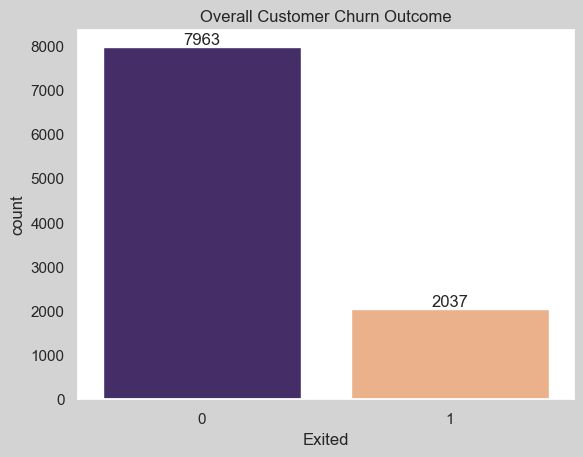

In [128]:
sb.set_theme(rc={'axes.facecolor':'white', 'figure.facecolor':'lightgray'})
colors = ['#432371',"#FAAE7B", '#D4314C', '#5E0303', '#504AEC']

chart = sb.countplot(x = df["Exited"], hue = df["Exited"], palette=colors[0:2], legend=False, data = df);
chart.set_title("Overall Customer Churn Outcome")
for container in chart.containers:
    chart.bar_label(container)

A total of 7,963 customers were retained, and 2,037 customers churned.

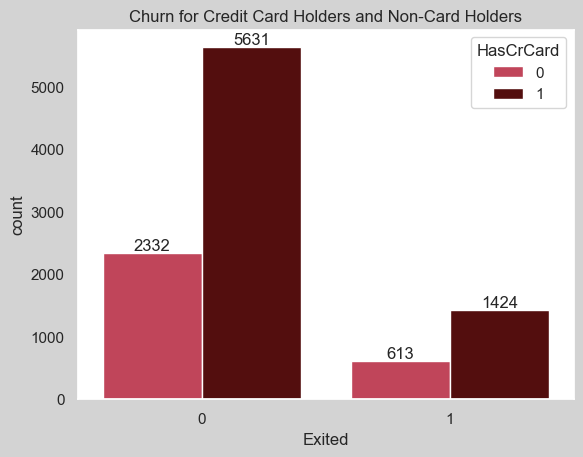

In [129]:
chart = sb.countplot(x = df["Exited"], hue = df["HasCrCard"], palette=colors[2:4]);
chart.set_title("Churn for Credit Card Holders and Non-Card Holders")
for container in chart.containers:
    chart.bar_label(container)

The majority of the people have credit cards, whether they churn or not.

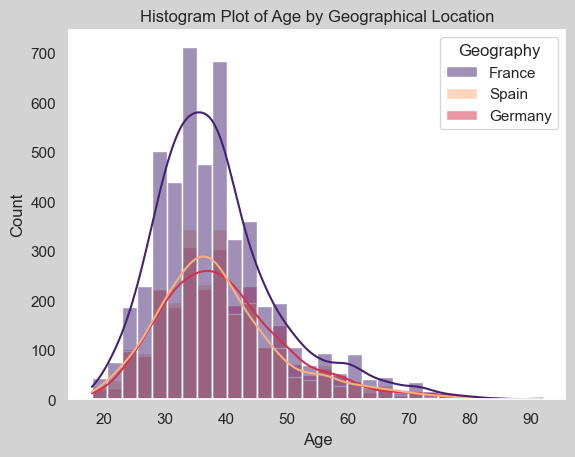

Mean Age   :  38.9
Median Age :  37.0


In [130]:
chart = sb.histplot(x = df['Age'], hue=df["Geography"], kde = True, bins = 30, palette = colors[0:3]);
chart.set_title("Histogram Plot of Age by Geographical Location")
plt.show()

print(f"Mean Age   : ", round(df["Age"].mean(),   1))
print(f"Median Age : ", round(df["Age"].median(), 1))

Over half of the observations are french, and the average age is 38.9. The median age is 37.0. The mean vs median, combined with visually inspecting the plot above indicates that the 'Age' variable has a skew to the right.

The sharp cutoff around 20 shows that the dataset does not include younger individuals, which could be explained by the bank having a minimum age requirement.

In [131]:
max_age = df["Age"].max()
min_age = df["Age"].min()

print(f"Maximum Age  : {max_age}")
print(f"Minimum Age  : {min_age}")
print(f"Range of Age : {max_age-min_age}")

Maximum Age  : 92
Minimum Age  : 18
Range of Age : 74


The right skew in Age is explained by the bank not allowing customers younger than 18 to bank with them. The skew occurs because the customers in the upper age range are fewer in number, yet still exist, as opposed to the lower age range (0-17) where these people are not allowed to be customers.

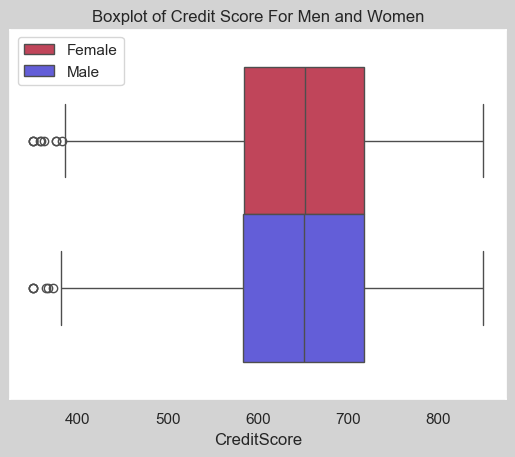

Mean Credit Score : 650.53


In [132]:
chart = sb.boxplot(x = df["CreditScore"], hue = df["Gender"], palette=(colors[2], colors[4]))
chart.legend(loc="upper left")
chart.set_title("Boxplot of Credit Score For Men and Women")
plt.show()

mean_cr_score = df["CreditScore"].mean()
print(f"Mean Credit Score : {round(mean_cr_score, 2)}")

The mean credit score for both men and women is nearly the same. Some outliers stretch out to the left and below 400.

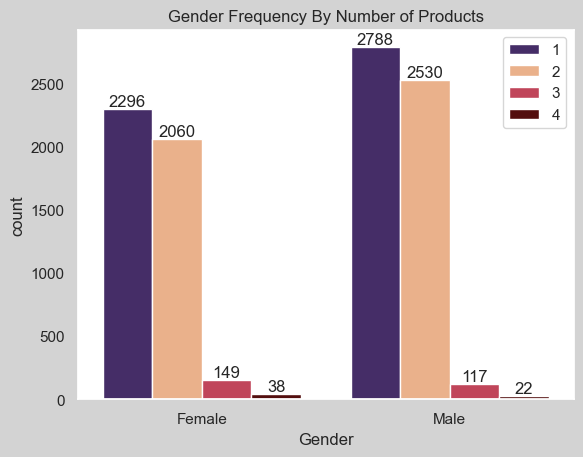

In [133]:
chart = sb.countplot(x = df["Gender"], hue = df["NumOfProducts"], palette=colors[0:4])
chart.set_title("Gender Frequency By Number of Products")
legend = chart.legend(loc = 'upper right')
legend.set_title(None)
for container in chart.containers:
    chart.bar_label(container)
plt.show()

The number of men and women in this dataset is almost even, with more men than women. Very few customers, regardless of gender, have more than 2 products. 

# Model Selection

### Distribution Analysis


First, we will examine the distributions of several variables in the dataset.

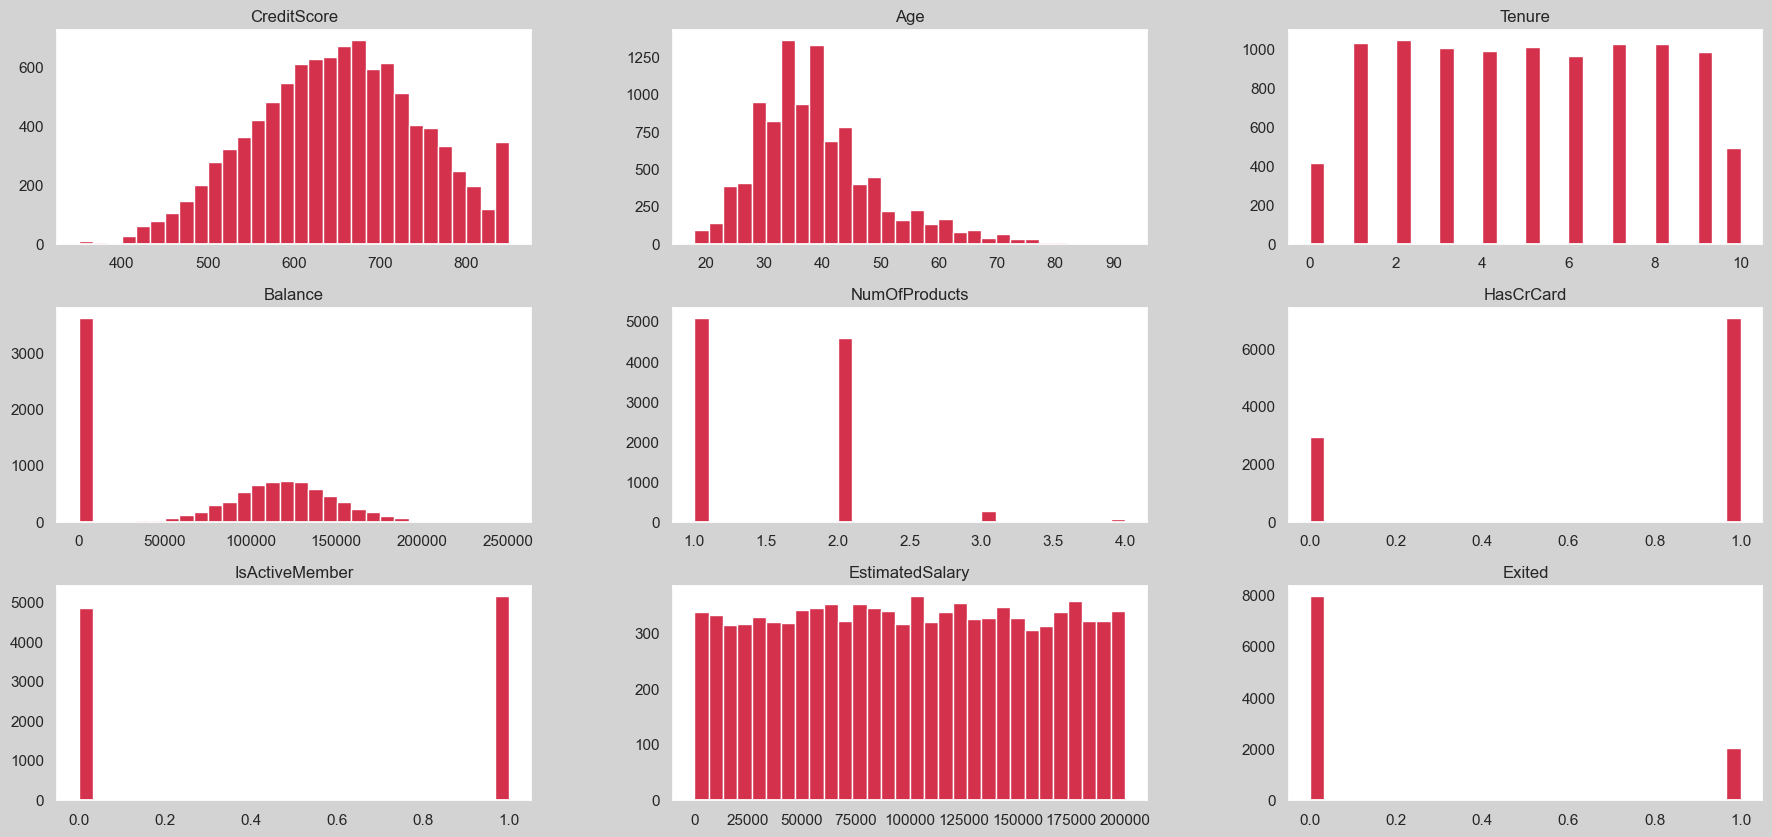

In [134]:
new_df.hist(bins = 30, figsize=(22, 10), color = '#D4314C');

Since this dataset is so large, it can be hard to tell exactly whether or not a distribution is normal. In order to proceed with my analysis, I will check for normality using the Anderson test.

I picked the Anderson test for the creditscore variable since more weight is given to the tails of the distribution. This is Useful in this situation because of the sharp uptick at the right-tail of 'CreditScore'. 

Additionally, the Anderson test is suitable for large sets of observations. The Shapiro-Wilk test for normality would probably determine the 'CreditScore' variable to be normally distributed, since it is an unsuitable test for large inputs.


In [135]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    # Suppress warning. 
    # The warning states the shapiro wilk test is inaccurate for N > 5000.
    # Current N is 10000
    stat, p = shapiro(X['CreditScore'])
    print(f"Shapiro-Wilk Test: Stat = {round(stat, 3)}, p-val = {p}\n")


result = anderson(X['CreditScore'])
print(f"Anderson Test: test-stat = {round(result.statistic, 3)}, Critical Values = {result.critical_values}")

Shapiro-Wilk Test: Stat = 0.994, p-val = 3.470965102195083e-20

Anderson Test: test-stat = 5.458, Critical Values = [0.576 0.656 0.787 0.918 1.092]


The Anderson test statistic is 5.458. The critical values [0.576 0.656 0.787 0.918 1.092] correspond to significance levels [15%, 10%, 5%, 2.5% 1%]. Since the test statistic is greater than all critical values, we reject the null hypothesis. 

Compare this to the Shapiro-Wilk test. Since its p-value is less than 0.05, we would reject the null hypothesis and determine that the data is normally distributed. However, since the Shapiro test is not suitable for this dataset, we will disregard it.

Therefore, the Anderson test determined that 'CreditScore' is not normally distributed.

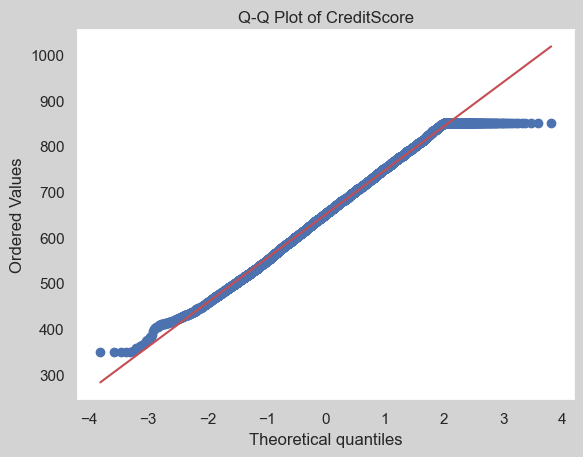

In [136]:
probplot(X['CreditScore'], dist = "norm", plot = plt)
plt.title("Q-Q Plot of CreditScore")
plt.show()

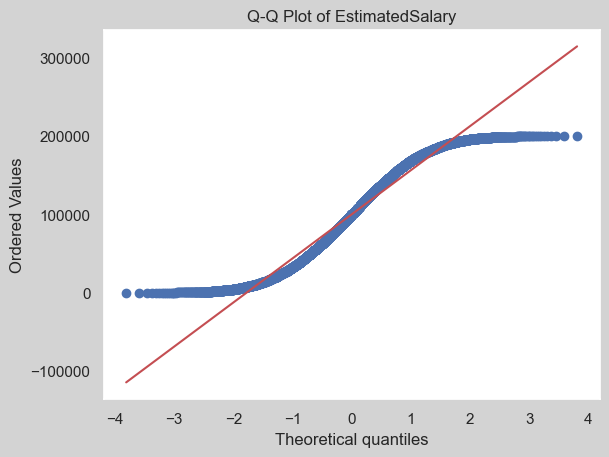

In [137]:
probplot(X['EstimatedSalary'], dist = "norm", plot = plt)
plt.title("Q-Q Plot of EstimatedSalary")
plt.show()

When looking at the "CreditScore" Q-Q Plot, it is obviously not normally distributed. Also, I threw in the "EstimatedSalary" Q-Q plot. It follows a more uniform like distribution.

We can visually inspect the previously produced histograms to determine that the "Balance" variable will behave simalarly.


### Why use a neural network

Since the output variable is binary, we could use multiple logistic regression. Logistic regression does not require a normal distribution. However, it would require manual feature engineering to capture non-linear relationships, whereas a neural network is capable of automatically learning these patterns. This greatly cuts down on the amount of pre-processing work, since we only need to encode the categorical variables and scale the numeric features.

The non-linear nature of this data, non-normal distribution, as well as the mix of categorical and quantitative data suggests that a neural network is a good model to build.

# Model Analysis

## Label Encoding

Upon manual observation, the dataset is sufficiently shuffled. The observations are not sorted based on geography, balance, credit score, or any other variable. Therefore, we don't necessarily need to concern our selves with shuffling the dataset before building the model.

Since we have two categorical variables, we must encode them before proceeding with the analysis.

In [138]:
adjust_length = 17 # offset for output formatting

for col in X:
    print(f"{col.ljust(adjust_length)} : {X[col].dtypes}")
print(f"{("Exited").ljust(adjust_length)} : {Y['Exited'].dtypes}")

CreditScore       : int64
Geography         : object
Gender            : object
Age               : int64
Tenure            : int64
Balance           : float64
NumOfProducts     : int64
HasCrCard         : int64
IsActiveMember    : int64
EstimatedSalary   : float64
Exited            : int64


The "Gender" variable will be encoded. A 0 represents the "Female" gender, a 1 represents the "Male" Gender.

Similarly, the "Geography" variable will be encoded. Each geographical location will recieve its own binary column, with a 1 occurring in the column where the observation is located.

In [139]:
Encoder = LabelEncoder()
X['Gender'] = Encoder.fit_transform(X.iloc[:, 2]).astype(int)

display((X.loc[:, 'CreditScore':'Gender']).iloc[0 : 5])


print(f"{str(X['Gender'].name)} : {X['Gender'].dtypes}")


,CreditScore,Geography,Gender
0,619,France,0
1,608,Spain,0
2,502,France,0
3,699,France,0
4,850,Spain,0


Gender : int64


Now, the "Gender" variable is represented as an integer.

Next, we must encode the "Geography" variable.

In [140]:
X = pd.get_dummies(X, columns=['Geography'], drop_first=True)

# Cast geography variables to integers
for col in X.columns:
    if 'Geography_' in col :
        X[col] = X[col].astype('int64')

Now all of the variables are represented numerically.

In [141]:
fin_df = X.copy()
fin_df['Exited'] = Y

display(fin_df.iloc[0 : 5])
for col in fin_df:
    print(f"{col.ljust(adjust_length)} : {fin_df[col].dtypes}")

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,0,0,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,0,42,8,159660.80,3,1,0,113931.57,0,0,1
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,1,0


CreditScore       : int64
Gender            : int64
Age               : int64
Tenure            : int64
Balance           : float64
NumOfProducts     : int64
HasCrCard         : int64
IsActiveMember    : int64
EstimatedSalary   : float64
Geography_Germany : int64
Geography_Spain   : int64
Exited            : int64


## Correlation Analysis

We will perform correlation analysis before scaling, but after encoding the data. This is since scaling affects the variance but not the relationship between the features. We analyze the correlation after encoding, since correlation analysis requires numeric data.

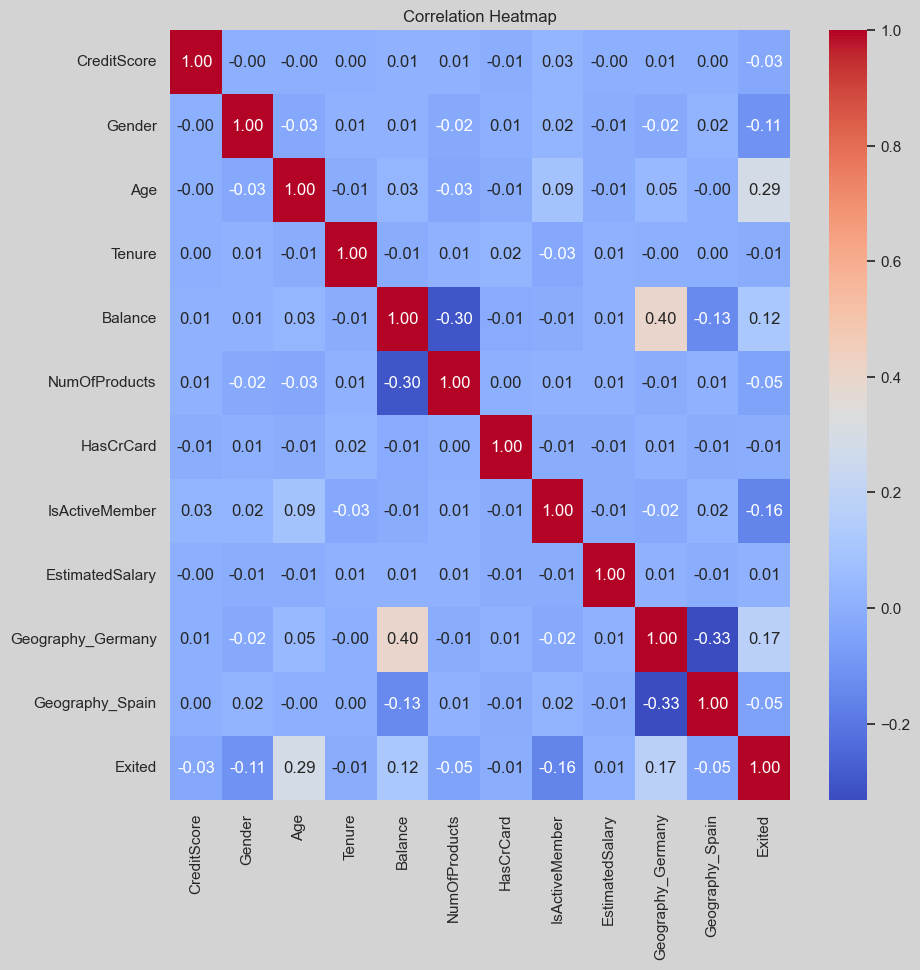

In [142]:
correlation_matrix = fin_df.corr()
plt.figure(figsize=(10,10))
sb.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm', fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

The row we will focus on the most is the "Exited" row. The strongest correlation is with "Age", which shows that age has a weak positive relation with "Exited". Other than that, there are only weakly correlations between the variables and the output.

Other notable correlations show that german customers are moderately positively correlated with balance. Additionally, we can say there is a weak negative correlation with the number of products a customer has and their balance. 

This could indicate that as their balance goes down, the number of products may increase. Let's examine this relationship further.

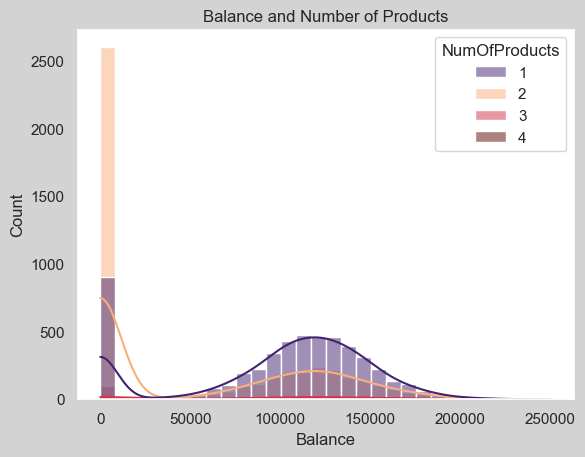

In [143]:
chart = sb.histplot(x = fin_df["Balance"], 
            hue = fin_df["NumOfProducts"], 
            bins = 30, 
            kde = True, 
            palette = colors[0:4])
chart.set_title("Balance and Number of Products")
plt.show()

As the majority of observations have a balance of zero, this relationship loses a lot of credibility. The rest of the balance values seem normally distributed, with their number of products staying relatively low. It is notable that almost nobody has 4 products.

## Feature Scaling


Now that the categorical variables have been encoded, we will scale the features. This step esures that the range of features is standardized.

It is important that only the quantitative variables are scaled. Categorical variables are now represented as integers, and the scaler would scale them if we let it. This would destroy the categorical variables. 

To proceed, I will split the data into "quantitative_cols" and "categorical_cols". Only the quantitative data will be scaled, then the categorical data will be concatenated with the scaled quantitative data.

I will detail this step with additional comments, since I have made this mistake in the past, and I see it in other notebooks often.

In [144]:
# Separate data
quantitative_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
categorical_cols  = ["Gender", "HasCrCard", "IsActiveMember", "Geography_Germany", "Geography_Spain"]

# Create train / test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM)
scaler = StandardScaler()

# Scale quantitative data
X_train_scaled_quan = pd.DataFrame(scaler.fit_transform(X_train[quantitative_cols]), columns = quantitative_cols, index=X_train.index)

# Do not fit test data, only scale
X_test_scaled_quan  = pd.DataFrame(scaler.transform(X_test[quantitative_cols]), columns = quantitative_cols, index = X_test.index)

# Concatenate scaled quantitative data with categorical data
X_train_scaled = pd.concat([X_train_scaled_quan, X_train[categorical_cols]], axis=1)
X_test_scaled  = pd.concat([X_test_scaled_quan, X_test[categorical_cols]], axis = 1)


# Display scaled training data
display(X_train_scaled.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Gender,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain
9216,0.765493,-0.842293,1.723525,-1.220873,0.792867,-0.792237,1,1,1,0,0
7324,-0.445505,0.012056,1.723525,-1.220873,2.503014,0.570243,0,1,0,0,0
918,1.386518,-0.367655,-0.696731,-1.220873,0.792867,-0.319681,1,0,0,0,1
5902,0.454981,0.106983,1.377774,-1.220873,0.792867,-1.031874,1,1,0,0,0
2807,0.568835,-0.557510,-0.696731,1.083582,0.792867,0.242175,1,1,0,0,0


Now the quantitative data has been scaled, and the binary representations of the categorical data has been preserved.

## Building The Model

Now, we will construct our tensorflow neural network.

In [145]:
model = keras.Sequential() # initialize model

model.add(layers.InputLayer(shape=(X_train_scaled.shape[1],))) # define shape

model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))) # Input layer
model.add(layers.BatchNormalization())          # Normalize activations to stabilize and speed up training
model.add(layers.Dropout(0.4))                  # Dropout layer to prevent overfitting
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# Save for later
model2 = keras.models.clone_model(model)
model3 = keras.models.clone_model(model)

Next, we will compile and train the model.

## Model Training and Optimization

In this section, I will construct three models. The first is the most "accurate" and "precise" model. I believe the first model is the weakest, which I will explain.

The second model weights the churned customers, so the neural network is punished more for miscassifying churned customers as "safe". 

The last model is recall optimized, yet it has a high rate of false positives and lower overall accuracy.

Before we proceed, I will define some important terms.

### Definitions

* RECALL is the Amount of true positive occurrances divided by the sum of true positives and false negatives. The recall statistic answers the question, "Of all of the actual churned customers, how many did the model correctly predict as churned?" The higher the recall, the more churned customers that the model correctly classified. A lower recall rate indicates that the model struggles to predict which customers will churn.

* PRECISION is the amount of True positives divided by the sum of true positive and false positive occurrances. The precision statistic answers the quesion, "How many of the predicted to churn customers actually churned?" There is a tradeoff we need to consider between Recall and Precision. High precision often results in low recall, where we would catch fewer churned customers and avoid incorrectly classifying non-churned customers as churned. High recall would catch most churning customers, but may generate more false positives. In our case, we want to prioritize recall. This is because customer retention is much more important than preventing the incorrect classification of safe customers as churning. 

* The F1-SCORE combines recall and precision. It has a more complex formula. It provides you with a balanced measure of a models performance. A low F1 score indicates a poor balance of Recall and Precision.

* ACCURACY measures the proportion of correct predictions out of the total predictions made by the model. It answers the quesiont, "How often is the model correct?" Accuracy doesn't always tell the full story, in fact accuracy alone is a poor assessment of our model. In our case, non-churned customers dominate the dataset. Accuracy may be high even though the model may fail to predict the minority class accurately at all.

In [146]:
# Squeeze training data, and construct early stopping object.


# Stop when loss starts to plateau
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    restore_best_weights = True
)

# Squeeze and re-index the training output data, to avoid a ValueError
Y_train = Y_train.squeeze()
Y_train = Y_train.reset_index(drop=True)

### Non-Optimal Model

Observe the cell below. Notice the class weights at the top of the cell.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


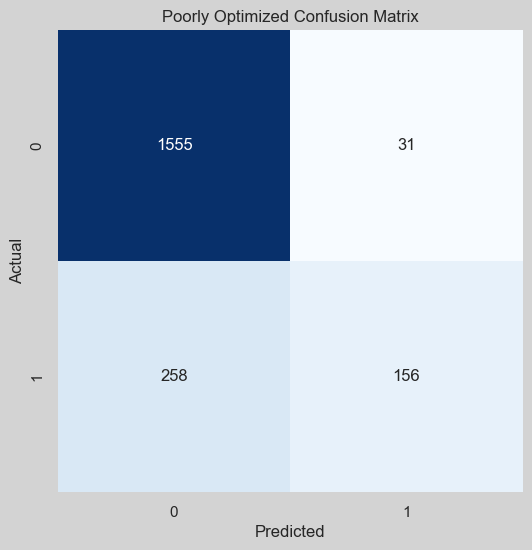

Poorly optimized model recall    = 0.38
Poorly optimized model precision = 0.83


Poorly optimized model f1-Score  = 0.52
Poorly optimized model accuracy  = 0.86


In [ ]:
# Classes are evenly weighted (default behavior)
class_weights = {0: 1.0, 1: 1.0}

# Compile model
tune2 = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=tune2,
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

# Train sub optimal model
history2 = model2.fit(X_train_scaled, Y_train,    
                    class_weight=class_weights, 
                    epochs = 75,                
                    batch_size = 32,            
                    validation_split = 0.2,     
                    callbacks = [early_stop],   
                    verbose = 0)     

# Cast predictions to integers
y_pred2 = (model2.predict(X_test_scaled) > 0.5).astype("int32")

# Create confusion matrix
con_matrix2 = confusion_matrix(Y_test, y_pred2)

# Display Confustion Matrix
plt.figure(figsize=(6, 6))
sb.heatmap(con_matrix2, annot=True, fmt='d', cmap='Blues', cbar = False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Poorly Optimized Confusion Matrix")
plt.show()

def analyze_model(test_data, pred_data, name):
    print(f"{name} recall    = {recall_score(test_data, pred_data):.2f}")
    print(f"{name} precision = {precision_score(test_data, pred_data):.2f}")
    print(f"\n")
    print(f"{name} f1-Score  = {f1_score(test_data, pred_data):.2f}")
    print(f"{name} accuracy  = {accuracy_score(test_data, pred_data):.2f}")

analyze_model(Y_test, y_pred2, "Poorly optimized model")

With this un-weighted model, it is very good at predicting retained customers, but not useful for providing insights on which customers will actually leave the bank.

This is the most "precise" and "accurate" model, but it is the poorest performing model. This is because the recall and the f1-score are the most important metrics for analyzing this dataset.

The recall on this model is 0.38, which means that the model is very bad at guessing whether or not a churned customer will be retained or not. Each churned customer is worth a lot of money to the bank, so we want to minimize the recall as much as possible. Now I will make another model, where the churned customers are weighted 3 times more than retained customers.

### Optimal Model

This model is the original model we built. 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


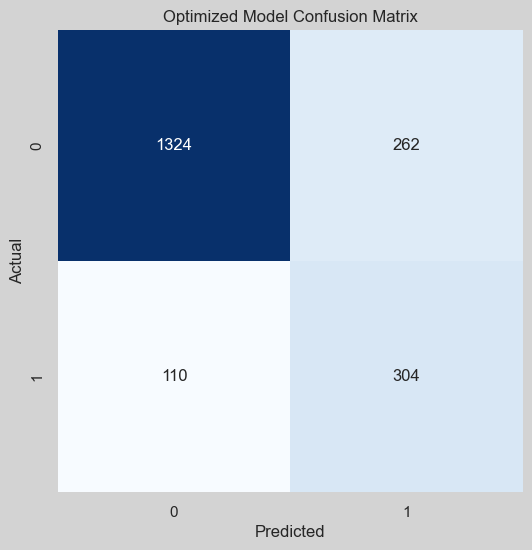

Optimized model recall    = 0.73
Optimized model precision = 0.54


Optimized model f1-Score  = 0.62
Optimized model accuracy  = 0.81


In [148]:
# Weight the churned customers, so that the model will consider them more
class_weights = {0: 1.0, 1: 3.5}

# Training
history = model.fit(X_train_scaled, Y_train,    # Input data
                    class_weight=class_weights, # Weight the churned customers
                    epochs = 75,                # Max number of epochs
                    batch_size = 32,            # Batch size
                    validation_split = 0.2,     # Use 20% of the trianing data for validation
                    callbacks = [early_stop],   # Use early stopping, to prevent overfitting
                    verbose = 0)                # Suppress output


# Cast predictions to integers
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Create confusion matrix
con_matrix = confusion_matrix(Y_test, y_pred)

# Display Confustion Matrix
plt.figure(figsize=(6, 6))
sb.heatmap(con_matrix, annot=True, fmt='d', cmap='Blues', cbar = False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Model Confusion Matrix")

if os.path.exists("/kaggle/"):
    save_path = "/kaggle/working/"
else:
    save_path = os.path.join(os.getcwd(), "plots")

os.makedirs(save_path, exist_ok = True)

plt.savefig(os.path.join(save_path, "good_confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

analyze_model(Y_test, y_pred, "Optimized model")

About 1300 customers were retained, and the model classified them as such. 262 customers were mistakenly predicted to churn. 110 customers left the bank without the model predicting it. 304 customers were predicted to churn, and the prediction was accurate. 

Using "class_weights = {0: 1.0, 1: 3.5}", means that the neural network will penalize itself 3.5 times harder when it misclassifies a churned customer. The reason why we need to do this is becaues the amount of churned customers is low compared to the amount of retained customers. We adjust the class weight, to tell the model that even though the churned customers are low in frequency, they are important.

Notice how this model's accuracy and especially precision are lower than the previous models. This tradeoff is acceptable, because we significantly increase our recall. This means that our optimized model is better able to predict which customers will churn better, instead of focusing so much on predicting which customers will be retained.

In [149]:
# display(Image(os.path.join(save_path, "good_confusion_matrix.png"), width = 600))
# analyze_model(Y_test, y_pred, "Optimized model")

### Recall Optimized Model


The recall rate could be further improved by increasing the class weight for churned customers. Even further, we could decrease the probability threshold for churned customers to 0.4, down from 0.5. This works, because the model outputs a series of probabilities. These probabilities represent the percentage chance that each specific customer churns. Previously, we used the 0.5 threshold. Decreasing it to 0.4 would classify a customer with a 43% chance of churning, as a churned customer.

Increasing the recall comes at the cost of increasing the false positive ocurrance rate. Decreasing the threshold also increases the false positive rate.

This is the line where the threshold is decreased :

`y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")`

In this model, I will increase the weight for churned customers to 4.0, and decrease the prediction threshold for churned customers to 0.4, down from 0.5. 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


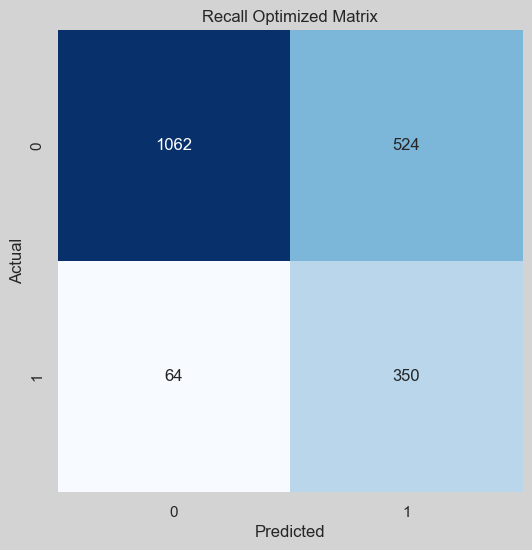

Recall optimized model recall    = 0.85
Recall optimized model precision = 0.40


Recall optimized model f1-Score  = 0.54
Recall optimized model accuracy  = 0.71


In [ ]:
# Churned customers class weight increased
class_weights3 = {0: 1.0, 1: 4.0}# 3.0 -> 4.0

# Recompile cloned model
tune3 = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=tune3,
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

# Train model 3
history3 = model3.fit(X_train_scaled, Y_train,    
                    class_weight=class_weights3, 
                    epochs = 75,                
                    batch_size = 32,            
                    validation_split = 0.2,     
                    callbacks = [early_stop],   
                    verbose = 0)     


# Super recall optimized model
y_pred3 = (model3.predict(X_test_scaled) > 0.4).astype("int32")# 0.5 -> 0.4
con_matrix3 = confusion_matrix(Y_test, y_pred3)

# Display Confustion Matrix
plt.figure(figsize=(6, 6))
sb.heatmap(con_matrix3, annot=True, fmt='d', cmap='Blues', cbar = False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Recall Optimized Matrix")
plt.show()

analyze_model(Y_test, y_pred3, "Recall optimized model")

With this threshold, the recall is significantly improved, and the false positive rate is also increased. 

Notice how the overall accuracy decreases. This would be an acceptable trade off if we needed to minimize false negatives as much as possible.

We will finish off with some final exploratory data analysis to help us decide which model is best.

Let's take a look at the bank account balance of our customers, and their churn outcomes.

In [151]:
print(f"Median bank account balance : {fin_df["Balance"].median():.2f}")
print(f"Mean bank account balance   : {fin_df["Balance"].mean():.2f}")

Median bank account balance : 97198.54
Mean bank account balance   : 76485.89


The average balance of the bank customers is 76,485. Remember, A lot of the bank's customers have a balance of zero. The 0 balance customers bring the average down significantly.

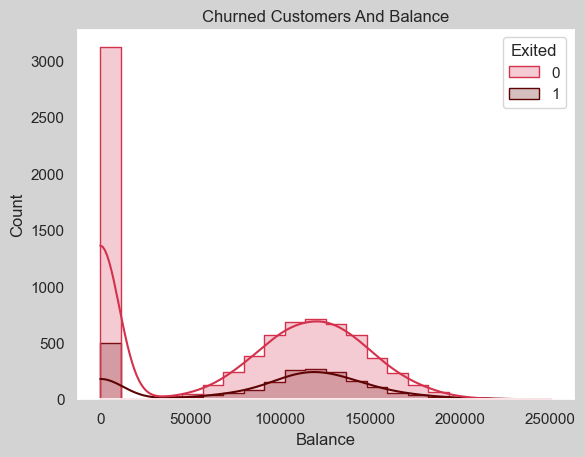

In [152]:
chart = sb.histplot(x = fin_df['Balance'], hue=fin_df['Exited'], kde =True, element = 'step', palette=colors[2:4]);
chart.set_title("Churned Customers And Balance")
plt.show()

# Conclusions

### Final Model Analysis

Choosing which model to use depends on the bank's churn prevention strategty. If their strategy is costly, it would be beneficial to pick the most balanced model. This model has a good ability to predict churned customers, and keeps the amount of false positives fairly low. This would be a good pick for a bank with a costly churn prevention strategy, because the bank would not waste too much money on customers that would have stayed with the bank anyways.

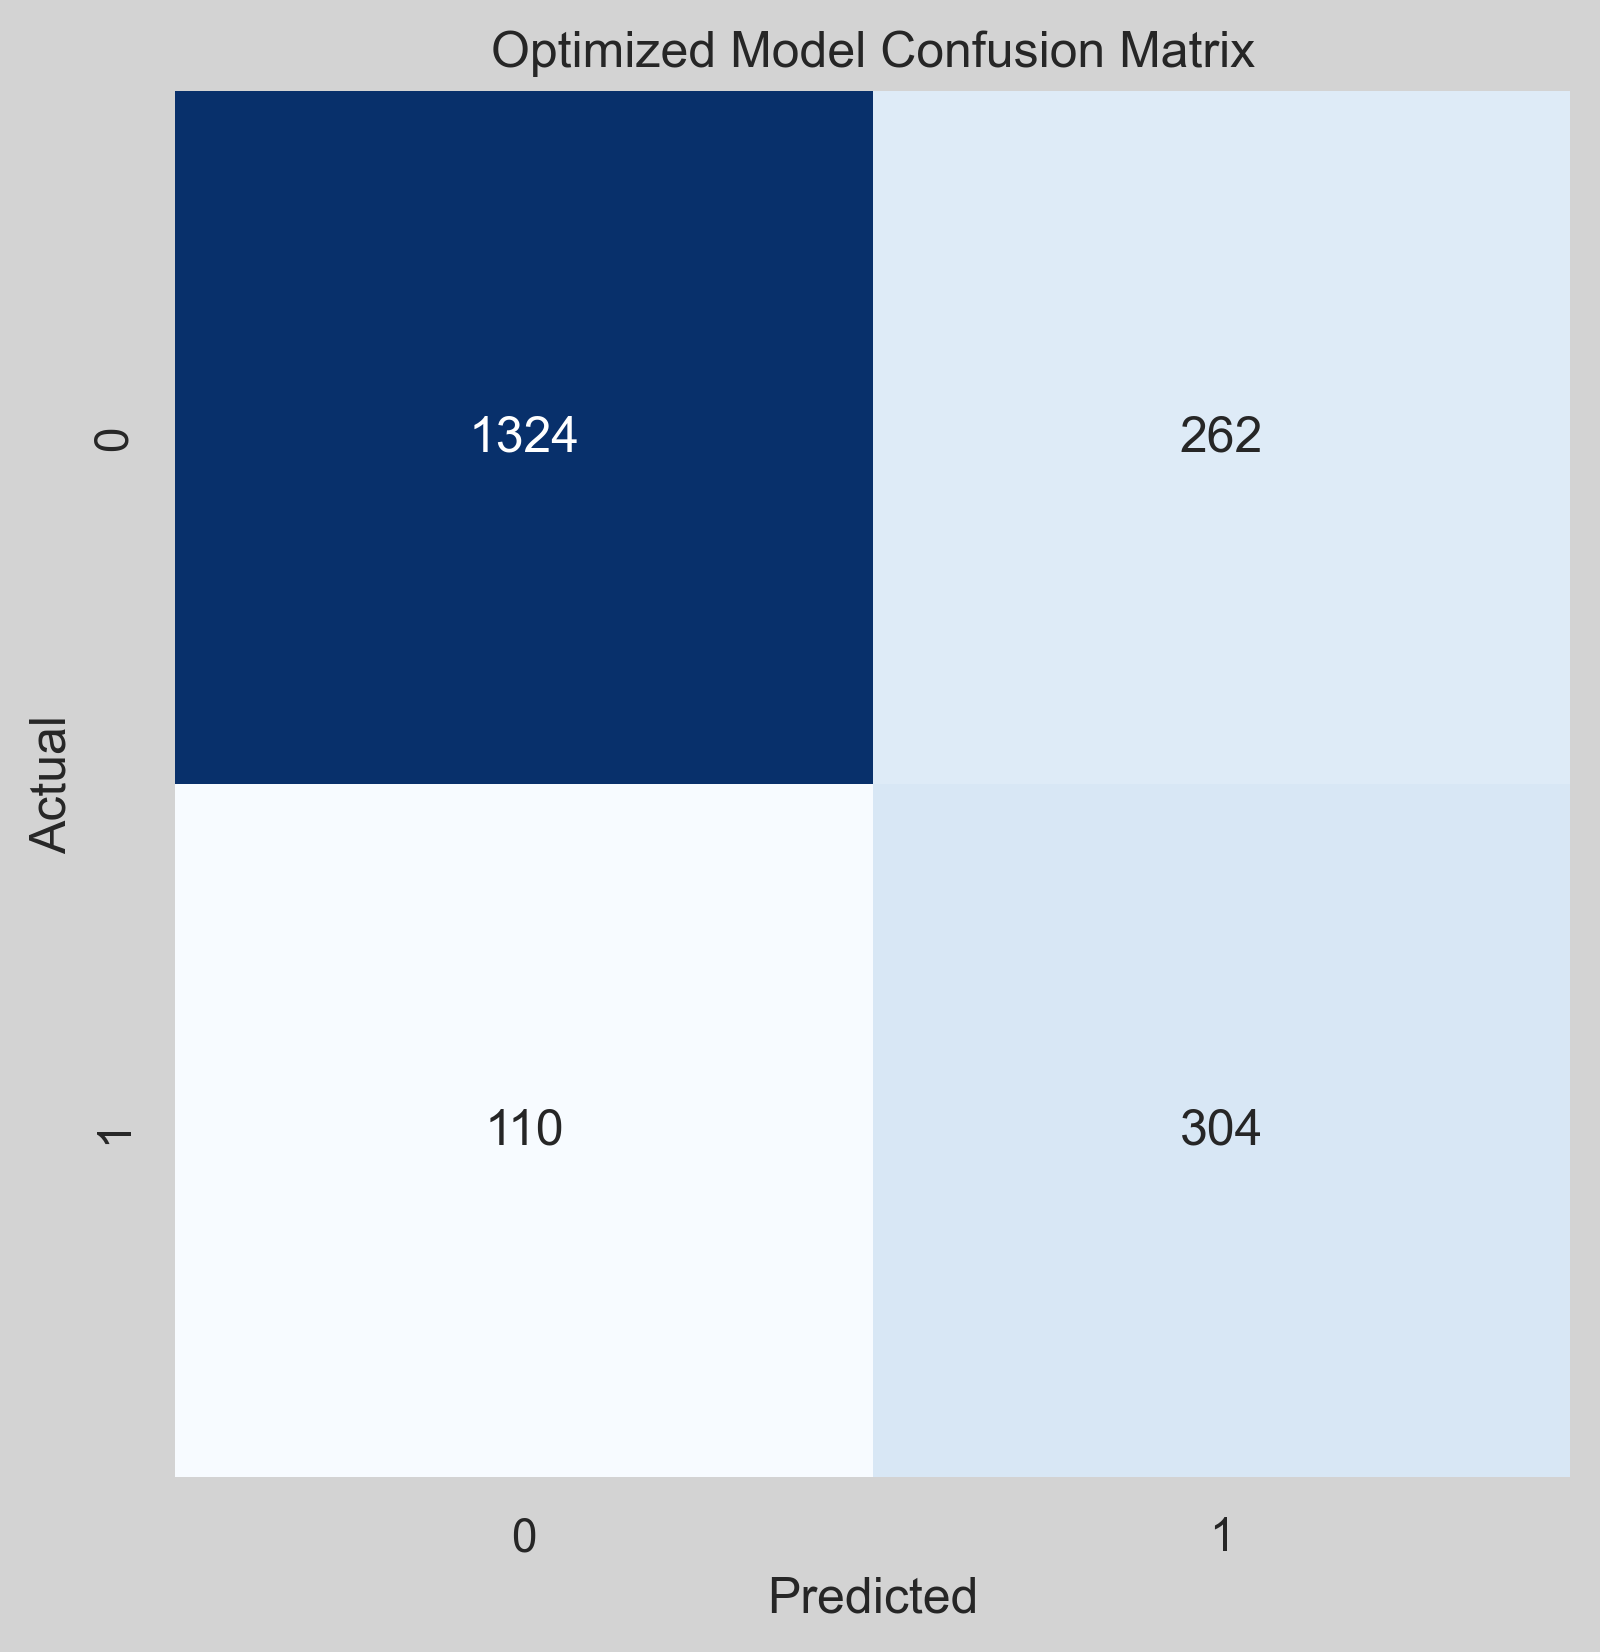

Optimized model recall    = 0.73
Optimized model precision = 0.54


Optimized model f1-Score  = 0.62
Optimized model accuracy  = 0.81


In [153]:
display(Image(os.path.join(save_path, "good_confusion_matrix.png"), width = 600))
analyze_model(Y_test, y_pred, "Optimized model")

To aid in our decision making, let's take a look at the ROC curve for each model.

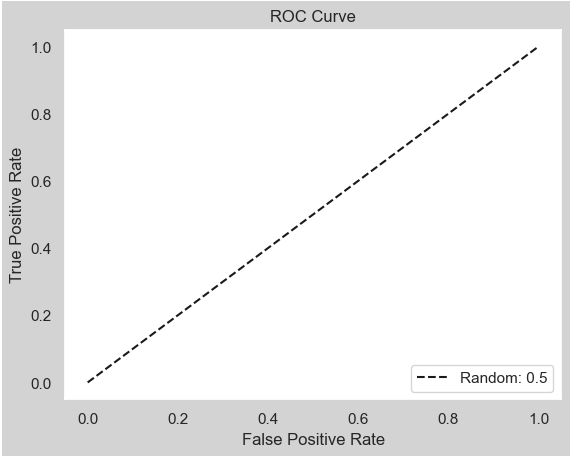

In [160]:
plt.figure(linewidth = 1)
#plt.plot(roc_curve(Y_test, y_pred))
plt.plot([0, 1], [0, 1], 'k--', label = 'Random: 0.5')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

-----intrepret roc curves : 5 sentences -----

### Concluding Thoughts

Working on this project has taught me how important it is to understand your dataset. Model accuracy alone does not give you the whole picture, it is important to step back and assess what your model must do, and focus on delivering a solution that fits your situation. 

If a bank had exclusively high balance customers, then it would be in that banks best interest to use the recall optimized model. For a more general bank with typical customers, the balanced model provides the best "one-size-fits-all" solution. This model balances the false positive rate with recall, allowing the bank to maximize revenue.

Further model development could potentially involve dynamically decreasing the prediction threshold for customers with a very high balance. This would be a good idea since customers with a high balance are very valuable to the bank. 

I'm sure this is a strategy real banks use, as high balance customers are very valuable and they could afford to lose some money chasing after false positives with high balances, as they are fewer in number compared to customers with less money.

### Summary

In this notebook, I created an import script which detects if the "Churn_Modelling.csv" is downloaded or not. If we need to download the dataeset, it retrieves it, whether you are on a windows machine or in the kaggle development environment. 

Then I cleaned the data, and performed exploratory analysis. This analysis was key, as it formed the foundation of my decision to build a neural network. I built 3 different models and compared them all to each other. After trianing the models, I deteremined that the balanced model was the best pick. I picked the balanced model because of its ability to correctly classify the churned customers, while keeping the false positive occurrances relatively low.


to-do: 

       - Add AUC/ROC curve analysis
       - Write Introduction
       - Review + Document
       - Publish

